In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3, dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [22]:
def mat_raideur_elementaire(indice, elements3, coordinates, f):
    #récupère les points du triangle
    triangle = elements3[indice]
    #récupère les coordonées des points
    [x1,y1] = coordinates[triangle[0]]
    [x2,y2] = coordinates[triangle[1]]
    [x3,y3] = coordinates[triangle[2]]
    #calcul de alpha
    alpha = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 -x1)
    #calcul des gradients
    gradients = np.zeros((3,2))
    gradients[0] = np.multiply([y2 - y3, x3 - x2],(1/alpha))
    gradients[1] = np.multiply([y3 - y1, x1 - x3],(1/alpha))
    gradients[2] = np.multiply([y1 - y2, x2 - x1],(1/alpha))
    #calcul de l'aire du triangle
    T = alpha / 2
    #calcul de M
    M = T * np.dot(gradients,np.transpose(gradients))
    #calcul du second terme
    #calcul du barycentre
    xg = (x1+x2+x3) / 3
    yg = (y1+y2+y3) / 3
    z = (alpha / 6)*f(xg, yg)
    return [M, z]


def assemblage_A(elements3, coordinates, ud, dirichlet, f):
    #récupère le nombre de triangles
    Nt = len(elements3)
    #récupère le nombre de points
    Np = len(coordinates)
    #création de la matrice A et b
    A = np.zeros((Np, Np))
    b = np.zeros(Np)
    uh = np.zeros(Np)
    for l in dirichlet:
        uh[l[0]] = ud(coordinates[l[0]][0], coordinates[l[0]][1])
    #On boucle sur les triangles
    for i in range (0,Nt):
        [Mt, z] = mat_raideur_elementaire(i, elements3, coordinates, f)
        triangle = elements3[i]
        for ii in range(3):
            for jj in range (3):
                A[triangle[ii]][triangle[jj]] += Mt[ii][jj]
            b[triangle[ii]] += z
    b = b - np.dot(A,uh)
    return A,b


#sous matrice de A en enlevant les valeurs à la frontière
def sous_matrice(A, b, dirichlet, n):
    indice = np.setdiff1d(np.array(range(n*n)), dirichlet)
    Abis = A[indice]
    Abis = np.transpose(Abis)
    Abis = Abis[indice]
    Abis = np.transpose(Abis)
    bbis = b[indice]
    return Abis,bbis,indice
                          
    

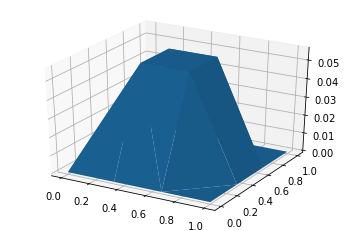

In [92]:
n = 4
coordinates, elements3, dirichlet, neumann = maillage(n)
def ud(x,y):
    return 0

def f(x,y):
    return 1
[A, b] = assemblage_A(elements3, coordinates, ud, dirichlet, f)
Abis,bbis,indice = sous_matrice(A,b,dirichlet,n)
u = np.zeros(n*n)
for i in dirichlet:
    u[i[0]] = ud(coordinates[i[0]][0],coordinates[i[0]][1])
u[indice] = np.linalg.solve(Abis, bbis)
show(coordinates,u)

In [24]:
print(np.linalg.norm(u-(np.sin(np.pi*coordinates[:,0])*np.sin(np.pi*coordinates[:,1]))/(2*np.pi**2)))

5.929388807984403


In [25]:
i = np.array([1, 3])
A = np.array([[1,2,3,4], [5,6,7,8], [5,6,7,8], [5,6,7,8]])

print(dirichlet.flatten())

[ 0  1  2  3  4  5  6  7  8  9 19 29 39 49 59 69 79 89 99 98 97 96 95 94
 93 92 91 90 80 70 60 50 40 30 20 10]


**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [80]:
def mat_raideur_elementaire_quadrangle(indice, elements4, coordinates, f):
    #récupère les points du triangle
    quadrangle = elements4[indice]
    #récupère les coordonées des points
    [x1,y1] = coordinates[quadrangle[0]]
    [x2,y2] = coordinates[quadrangle[1]]
    [x3,y3] = coordinates[quadrangle[2]]
    [x4,y4] = coordinates[quadrangle[3]]
    #calcul de alpha
    alpha = ((x2 - x1)*(y4 - y1) - (y2 - y1)*(x4 -x1))/6
    #Calcul de la matrice M
    M = np.zeros((4,4))
    #Calcul des coordonnées de [J'J]**(-1)
    J = np.zeros((2,2))
    J[0,0] = (x2 - x1)
    J[1,0] = (y2 - y1)
    J[0,1] = (x4 - x1)
    J[1,1] = (y4 - y1)
    P = np.dot(np.transpose(J),J)
    #calcul des coefs
    det =P[1,1]*P[0,0] - P[1,0]**2
    a = P[1,1]/det
    b = -P[1,0]/det
    c = P[0,0]/det
    #calcul de M
    M[0,0] = 2*a+3*b+2*c
    M[1,1] = 2*a-3*b+2*c
    M[2,2] = 2*a+3*b+2*c
    M[3,3] = 2*a-3*b+2*c
    M[1,0] = -2*a+c
    M[0,1] = -2*a+c
    M[2,0] = -a-3*b-c
    M[0,2] = -a-3*b-c
    M[2,1] = a-2*c
    M[1,2] = a-2*c
    M[3,0] = a-2*c
    M[0,3] = a-2*c
    M[3,1] = -a+3*b-c
    M[1,3] = -a+3*b-c
    M[3,2] = -2*a+c
    M[2,3] = -2*a+c
    #calcul du second terme
    #calcul du barycentre
    xg = (x1+x3) / 2
    yg = (y1+y3) / 2
    z = ((alpha*6)/4)*f(xg, yg)
    return [M, z]



def assemblage_mixte_A(elements3, elements4, coordinates, ud, g, f, dirichlet, neumann):
    #récupère le nombre de triangles
    Nt = len(elements3)
    #récupère le nombre de quadrangle
    Nq = len(elements4)
    #récupère le nombre de points
    Np = len(coordinates)
    #création de la matrice A et b
    A = np.zeros((Np, Np))
    b = np.zeros(Np)
    uh = np.zeros(Np)
    for l in dirichlet:
        uh[l] = ud(coordinates[l][0], coordinates[l][1])
        
    #On boucle sur les triangles 
    for i in range (0,Nt):
        [Mt, z] = mat_raideur_elementaire(i, elements3, coordinates, f)
        triangle = elements3[i]
    for ii in range(3):
        for jj in range (3):
            A[triangle[ii]][triangle[jj]] += Mt[ii][jj]
        b[triangle[ii]] += z
    b = b - np.dot(A,uh)

    #On boucle sur les quadrangles
    for i in range (0,Nq):
        [Mt, z] = mat_raideur_elementaire_quadrangle(i, elements4, coordinates, f)
        quadrangle = elements4[i]
        for ii in range(4):
            for jj in range (4):
                A[quadrangle[ii]][quadrangle[jj]] += Mt[ii][jj]  
    for i in range(Np):
        s = 0
        for k in neumann:
            if i in k:
                [xd, yd] = coordinates[k[0]]
                [xq, yq] = coordinates[k[1]]
                b[i] += (1/2)*(math.sqrt((xd-xq)**2+(yd-yq)**2))*g((xd+xq)/2,(yd + yq)/2)
    return A,b




[2.80804492e-05 8.31181296e-04 2.80804492e-05 1.12321797e-04
 1.31978111e-04 1.12321797e-04]
[ 1  3  5 12 13 14]


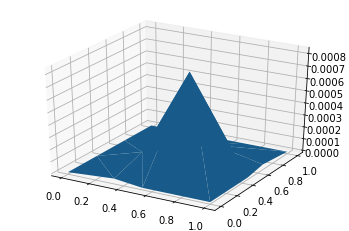

In [94]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])
n = 4
def g(x,y):
    return 0

def ud(x,y):
    return 0

def f(x,y):
    return 1

[A, b] = assemblage_mixte_A(e3, e4, ccs, ud, g, f, dds, nns)
Abis,bbis,indice = sous_matrice(A,b,dds,n)
print(np.linalg.solve(Abis, bbis))
u = np.zeros(n*n)
for i in dds:
    u[i] = ud(ccs[i][0],ccs[i][1])
u[indice] = np.linalg.solve(Abis, bbis)
print(indice)
show(ccs,u)

In [28]:
print(neumann)

[]


**Compléments  :  un nouveau terme dans l'EDP**